In [20]:
import numpy as np
import glob
import os
from matplotlib import pyplot
from matplotlib.image import imread
import matplotlib.ticker as mtick
%matplotlib inline
%pylab inline
import seaborn as sns

from PIL import Image, ImageOps
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

import keras
from keras.models import Sequential, load_model
from keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout, BatchNormalization, GaussianNoise, LeakyReLU
from keras.metrics import Precision, Recall
from keras.applications import Xception, VGG16
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras import optimizers

from sklearn import metrics

Populating the interactive namespace from numpy and matplotlib


C:\Users\bjane\Miniconda3\envs\learn-env\lib\site-packages\IPython\core\magics\pylab.py:160: UserWarning: pylab import has clobbered these variables: ['imread']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [2]:
# define path to save model
model_path = './Xception_best_model_fully_trained.h5'

callbacks = [EarlyStopping(monitor='val_accuracy', 
                           patience=10,
                           mode='max',
                           verbose=1),
             ModelCheckpoint(model_path,
                             monitor='val_accuracy', 
                             save_best_only=True, 
                             mode='max',
                             verbose=0)]

In [3]:
# define model evaluation
def model_evaluation(history, p_r_iteration=2):

    # set context for plots
    sns.set_style('darkgrid') 
    sns.set_context('talk') 
    
    # define number of epochs
    epochs = range(1, len(history.history['accuracy'])+1)
    
    # plot accuracy
    plt.figure(figsize=(15,8))
    pyplot.title("Accuracy") 
    ax = plt.plot(epochs, history.history['accuracy'], color='blue', label='Train Data') 
    ax = plt.plot(epochs, history.history['val_accuracy'], color='orange', label='Validation Data') 
    plt.xticks(np.arange(min(epochs), max(epochs)+1, 5))
    plt.legend()
    
    # plot recall
    plt.figure(figsize=(15,8))
    pyplot.title("Precision") 
    plt.plot(epochs, history.history['recall_{}'.format(p_r_iteration)], color='blue', label='Train Data') 
    plt.plot(epochs, history.history['val_recall_{}'.format(p_r_iteration)], color='orange', label='Validation Data') 
    plt.xticks(np.arange(min(epochs), max(epochs)+1, 5))
    plt.legend()
    
    # plot precision
    plt.figure(figsize=(15,8))
    pyplot.title("Recall") 
    plt.plot(epochs, history.history['precision_{}'.format(p_r_iteration)], color='blue', label='Train Data') 
    plt.plot(epochs, history.history['val_precision_{}'.format(p_r_iteration)], color='orange', label='Validation Data') 
    plt.xticks(np.arange(min(epochs), max(epochs)+1, 5))
    plt.legend()

In [4]:
# directory path
train_data_dir = 'chest_xray/train'
test_data_dir = 'chest_xray/test'

In [5]:
# create new instances for Xception model
generator_Xception = ImageDataGenerator(rescale = 1.0/255.0,
                                        validation_split=0.10,
                                        horizontal_flip=True)

generator_Xception_test = ImageDataGenerator(rescale = 1.0/255.0)
                                         
# Get all the data in the directory chest_xrays/train and resize
train_gen_Xception = generator_Xception.flow_from_directory(
        train_data_dir, 
        target_size=(112, 112), 
        class_mode='binary',
        batch_size=64,
        color_mode='rgb',
        subset='training')

# create a validation dataset
val_gen_Xception = generator_Xception.flow_from_directory(
        train_data_dir, 
        target_size=(112, 112), 
        class_mode='binary',
        batch_size=64,
        color_mode='rgb',
        subset='validation')

# Get all the data in the directory chest_xrays/test and resize
test_gen_Xception = generator_Xception_test.flow_from_directory(
        test_data_dir, 
        target_size=(112, 112), 
        class_mode='binary',
        batch_size=64, 
        color_mode='rgb')

Found 4695 images belonging to 2 classes.
Found 521 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


For this experiment we will use Leaky ReLU activations rather than ReLU in our final dense layers. Also, we will use AdaGrad as our optimizer as opposed to Adam.

In [15]:
# define Xception model
def create_Xception_model(classification_threshold=0.5):

    # load Xception model
    cnn_base = Xception(include_top=False, input_shape=(112, 112, 3))
    
    # do not mark Xception model layers as untrainable
    #cnn_base.trainable = False
    
    # initialize model
    model = Sequential()
    
    # add CNN base
    model.add(cnn_base)
    
    # add flattening layer
    model.add(Flatten())
    
    # add dense layer
    model.add(Dense(128, activation=None, kernel_initializer='he_uniform'))
    
    # add leaky ReLU activation
    model.add(LeakyReLU(0.3))
    
    # add dropout layer
    model.add(Dropout(0.4))
    
    # add second dense layer
    model.add(Dense(64, activation=None, kernel_initializer='he_uniform'))
    
    # add leaky ReLU activation
    model.add(LeakyReLU(0.3))

    # add output layer
    model.add(Dense(1, activation='sigmoid', kernel_initializer='he_uniform'))

    # custom decaying optimizer
    #optimizer = optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
    opt = optimizers.SGD(lr=0.001, momentum=0.9)
    
    # compile model
    model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy', Precision(classification_threshold), 
                                                                         Recall(classification_threshold)])
    
    return model

In [16]:
# create Xception model
Xception_model = create_Xception_model(classification_threshold=0.50)

In [17]:
# train model
history_Xception = Xception_model.fit_generator(train_gen_Xception, steps_per_epoch=len(train_gen_Xception), 
                                         epochs=50, validation_data=val_gen_Xception, validation_steps=len(val_gen_Xception),
                                         callbacks=callbacks)

Epoch 1/50
74/74 [==============================] - 1330s 18s/step - loss: 0.3150 - accuracy: 0.8739 - precision_4: 0.8980 - recall_4: 0.9366 - val_loss: 0.2022 - val_accuracy: 0.9175 - val_precision_4: 0.9725 - val_recall_4: 0.9147
Epoch 2/50
74/74 [==============================] - 1386s 19s/step - loss: 0.1072 - accuracy: 0.9585 - precision_4: 0.9687 - recall_4: 0.9756 - val_loss: 0.1299 - val_accuracy: 0.9328 - val_precision_4: 0.9536 - val_recall_4: 0.9561
Epoch 3/50
74/74 [==============================] - 1271s 17s/step - loss: 0.0831 - accuracy: 0.9691 - precision_4: 0.9785 - recall_4: 0.9799 - val_loss: 0.0858 - val_accuracy: 0.9501 - val_precision_4: 0.9713 - val_recall_4: 0.9612
Epoch 4/50
74/74 [==============================] - 1248s 17s/step - loss: 0.0616 - accuracy: 0.9774 - precision_4: 0.9834 - recall_4: 0.9862 - val_loss: 0.0446 - val_accuracy: 0.9463 - val_precision_4: 0.9687 - val_recall_4: 0.9587
Epoch 5/50
74/74 [==============================] - 1270s 17s/step -

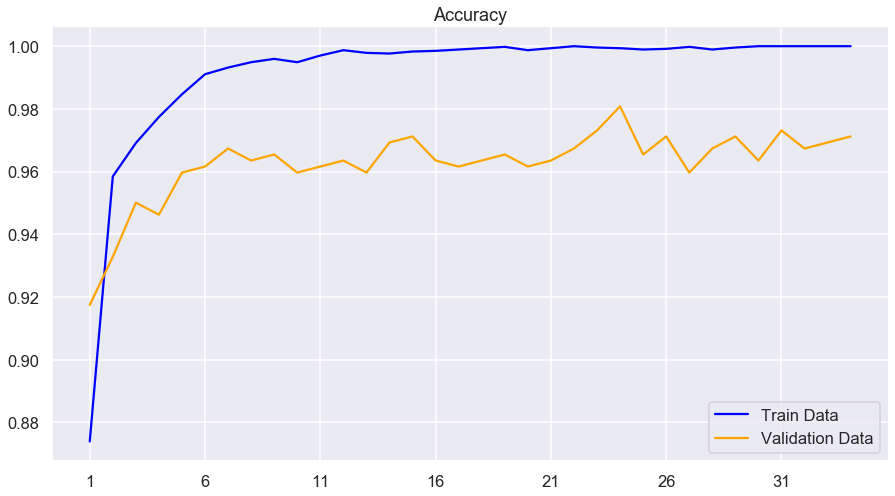

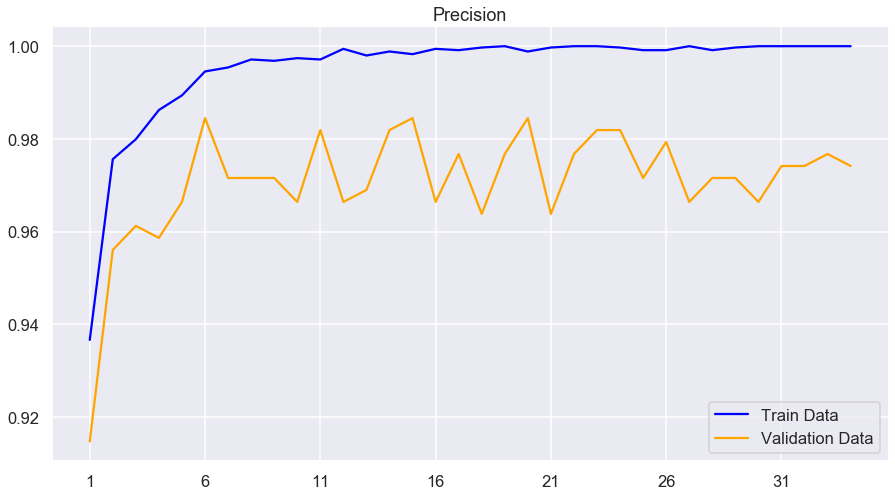

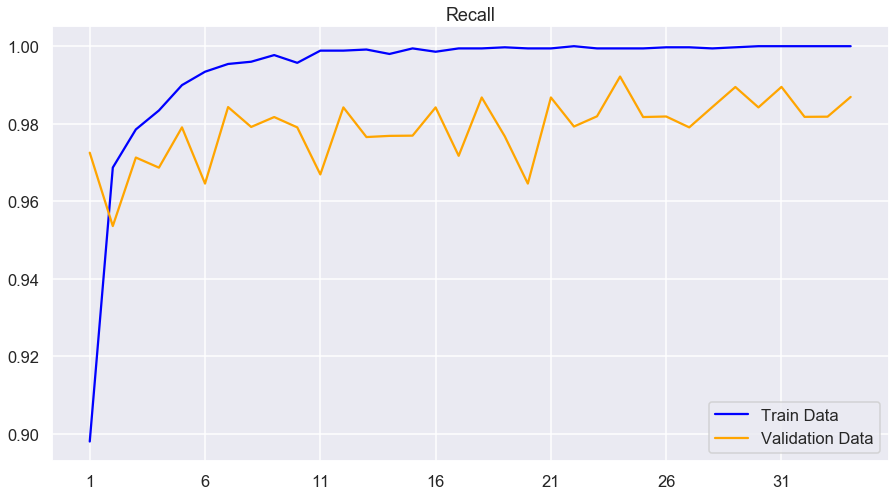

In [18]:
# evaluate model
model_evaluation(history_Xception, p_r_iteration=4)

In [23]:
# evaluate on test set

Xception_test_accuracy = Xception_model.evaluate_generator(test_gen_Xception, steps=len(test_gen_Xception))[1]
Xception_test_precision = Xception_model.evaluate_generator(test_gen_Xception, steps=len(test_gen_Xception))[2]
Xception_test_recall = Xception_model.evaluate_generator(test_gen_Xception, steps=len(test_gen_Xception))[3]

print("Test Set Accuracy: {}%".format(Xception_test_accuracy*100))
print("Test Set Precision: {}%".format(Xception_test_precision*100))
print("Test Set Recall: {}%".format(Xception_test_recall*100))

Test Set Accuracy: 82.85256624221802%
Test Set Precision: 78.58585715293884%
Test Set Recall: 99.74358677864075%


In [ ]:
# plot confusion matrix for test set
Y_pred_Xception = Xception_model.predict_generator(test_gen_Xception, 10, workers=0)
y_pred_Xception = np.where(Y_pred_Xception > 0.5, 1, 0)
print('Confusion Matrix')
cm = metrics.confusion_matrix(test_gen_Xception.classes, y_pred_Xception)
print(cm)
print('Classification Report')
print(metrics.classification_report(test_gen_Xception.classes, y_pred_Xception))

# Import Covid-19 Test Dataset

In [25]:
# directory path
test_data_dir_covid = 'chest_xray/test_covid19'

In [26]:
# import covid 19 test set
generator_Xception_test_covid = ImageDataGenerator(rescale = 1.0/255.0)
                                         
# Get all the data in the directory chest_xrays/test and resize
test_gen_Xception_covid = generator_Xception_test_covid.flow_from_directory(
        test_data_dir_covid, 
        target_size=(112, 112), 
        class_mode='binary',
        batch_size=64, 
        color_mode='rgb',
        shuffle=False)

Found 146 images belonging to 2 classes.


In [29]:
# evaluate on test set

Xception_test_accuracy = Xception_model.evaluate_generator(test_gen_Xception_covid, steps=len(test_gen_Xception_covid))[1]
Xception_test_precision = Xception_model.evaluate_generator(test_gen_Xception_covid, steps=len(test_gen_Xception_covid))[2]
Xception_test_recall = Xception_model.evaluate_generator(test_gen_Xception_covid, steps=len(test_gen_Xception_covid))[3]

print("Test Set Accuracy: {}%".format(Xception_test_accuracy*100))
print("Test Set Precision: {}%".format(Xception_test_precision*100))
print("Test Set Recall: {}%".format(Xception_test_recall*100))

Test Set Accuracy: 61.64383292198181%
Test Set Precision: 57.94392228126526%
Test Set Recall: 84.93150472640991%


In [30]:
# plot confusion matrix for test set
Y_pred_Xception = Xception_model.predict_generator(test_gen_Xception, 10, workers=0)
y_pred_Xception = np.where(Y_pred_Xception > 0.5, 1, 0)
print('Confusion Matrix')
cm = metrics.confusion_matrix(test_gen_Xception.classes, y_pred_Xception)
print(cm)
print('Classification Report')
print(metrics.classification_report(test_gen_Xception.classes, y_pred_Xception))

Confusion Matrix
[[ 45 189]
 [ 84 306]]
Classification Report
              precision    recall  f1-score   support

           0       0.35      0.19      0.25       234
           1       0.62      0.78      0.69       390

    accuracy                           0.56       624
   macro avg       0.48      0.49      0.47       624
weighted avg       0.52      0.56      0.53       624

